<a href="https://colab.research.google.com/github/PDOTXITE/Multi_label_Xray_Image_classification/blob/main/MultiLabel_Xray_Image_ClassificationFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

download dataset --> https://drive.google.com/uc?export=download&id=1icfjrw13-kIN1tnQrgMPWedlmV2cnW_c

In [ ]:
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/AI_builder/dataset.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: dataset/train/00010028_006.jpg  
  inflating: dataset/train/00027725_050.jpg  
  inflating: dataset/train/00022584_000.jpg  
  inflating: dataset/train/00023283_003.jpg  
  inflating: dataset/train/00019363_022.jpg  
  inflating: dataset/train/00011507_001.jpg  
  inflating: dataset/train/00000491_004.jpg  
  inflating: dataset/train/00000385_001.jpg  
  inflating: dataset/train/00015556_021.jpg  
  inflating: dataset/train/00021201_081.jpg  
  inflating: dataset/train/00006480_001.jpg  
  inflating: dataset/train/00002759_000.jpg  
  inflating: dataset/train/00007441_005.jpg  
  inflating: dataset/train/00013380_014.jpg  
  inflating: dataset/train/00010294_055.jpg  
  inflating: dataset/train/00016291_040.jpg  
  inflating: dataset/train/00000847_002.jpg  
  inflating: dataset/train/00011896_004.jpg  
  inflating: dataset/train/00009202_006.jpg  
  inflating: dataset/train/00020318_019.jpg  
  inflating: dataset/tr

In [ ]:
all_classes = ["Cardiomegaly","Hernia", "Infiltration", "Nodule", "Emphysema", "Effusion", "Atelectasis",
               "Pleural_Thickening", "Pneumothorax", "Mass", "Fibrosis", "Consolidation",
               "Edema", "Pneumonia"]
class_to_index = {c: i for i, c in enumerate(all_classes)}
num_classes = len(all_classes)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # ระบุคอลัมน์ที่เป็น label (ยกเว้น 'img_ind')
        self.labels_columns = self.img_labels.columns[:-1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # ใช้ -1 เพื่อเข้าถึงคอลัมน์สุดท้ายซึ่งเป็น 'img_ind'
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, -1])
        image = Image.open(img_path).convert("RGB")

        # อ่าน labels จากคอลัมน์ที่เลือกและแปลงเป็น tensor
        labels = self.img_labels.iloc[idx, :-1].values.astype('float32')
        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        return image, labels

Data augmentation


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CustomImageDataset(annotations_file='/content/dataset/train.csv', img_dir='/content/dataset/train', transform=train_transform)
val_dataset = CustomImageDataset(annotations_file='/content/dataset/val.csv', img_dir='/content/dataset/val', transform=val_test_transform)
test_dataset = CustomImageDataset(annotations_file='/content/dataset/test.csv', img_dir='/content/dataset/test', transform=val_test_transform)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Set up checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/AI_builder'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    tp = 0
    fp = 0
    fn = 0
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        with torch.no_grad():
            prediction = (torch.sigmoid(outputs) >= threshold).float()
            tp += torch.sum(labels * prediction).item()
            fp += torch.sum(torch.clamp(prediction - labels, min = 0, max = 1)).item()
            fn += torch.sum(torch.clamp(labels - prediction, min = 0, max = 1)).item()


        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    precision = tp / (tp+fp+1e-8)
    recall = tp / (tp+fn+1e-8)
    f1 = 2 * ((precision*recall) / (precision+recall+1e-8))

    last_loss = running_loss / len(train_loader)
    return last_loss, precision, recall, f1

Train MobilenetV2

In [ ]:
model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 14)

loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
threshold = 0.1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 80.8MB/s]


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, precision, recall, f1 = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    vtp = 0
    vfp = 0
    vfn = 0
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vprediction = (torch.sigmoid(voutputs) >= threshold).float()
            vtp += torch.sum(vlabels * vprediction).item()
            vfp += torch.sum(torch.clamp(vprediction - vlabels, min = 0, max = 1)).item()
            vfn += torch.sum(torch.clamp(vlabels - vprediction, min = 0, max = 1)).item()
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    vprecision = vtp / (vtp+vfp+1e-8)
    vrecall = vtp / (vtp+vfn+1e-8)
    vf1 = 2 * ((vprecision*vrecall) / (vprecision+vrecall+1e-8))
    avg_vloss = running_vloss / (i + 1)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('PRECISION train {} valid {}'.format(precision, vprecision))
    print('RECALL train {} valid {}'.format(recall, vrecall))
    print('F1 train {} valid {}'.format(f1, vf1))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # checkpoint
    model_path = os.path.join(checkpoint_dir, 'model_{}_{}.pt'.format(timestamp, epoch_number))
    torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
model_path = os.path.join(checkpoint_dir, 'mobilenetv2finalmodel.pth')
torch.save(model.state_dict(), model_path)

Test MobilenetV2

In [ ]:
PATH = '/content/drive/MyDrive/AI_builder/models/mobilenetv2finalmodel.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model.eval()
y_actual = []
y_predict = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        y_actual.extend(labels.cpu().numpy())
        y_predict.extend(preds.cpu().numpy())

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Convert lists to numpy arrays
y_actual = np.array(y_actual)
y_predict = np.array(y_predict)

# Compute the multilabel confusion matrix
matrix = multilabel_confusion_matrix(y_actual, y_predict)

# Compute and print the classification report
report = classification_report(y_actual, y_predict, target_names=list(all_classes))
print("\nClassification Report:")
print(report)


Classification Report:
                    precision    recall  f1-score   support

      Cardiomegaly       0.38      0.84      0.52       286
            Hernia       0.33      0.17      0.22        18
      Infiltration       0.41      0.99      0.58      2049
            Nodule       0.30      0.68      0.42       643
         Emphysema       0.39      0.74      0.51       257
          Effusion       0.36      0.96      0.52      1360
       Atelectasis       0.32      0.92      0.47      1151
Pleural_Thickening       0.15      0.51      0.23       299
      Pneumothorax       0.31      0.84      0.45       485
              Mass       0.40      0.76      0.52       603
          Fibrosis       0.21      0.39      0.28       175
     Consolidation       0.17      0.62      0.27       479
             Edema       0.19      0.73      0.30       229
         Pneumonia       0.00      0.00      0.00       144

         micro avg       0.33      0.83      0.47      8178
         macro

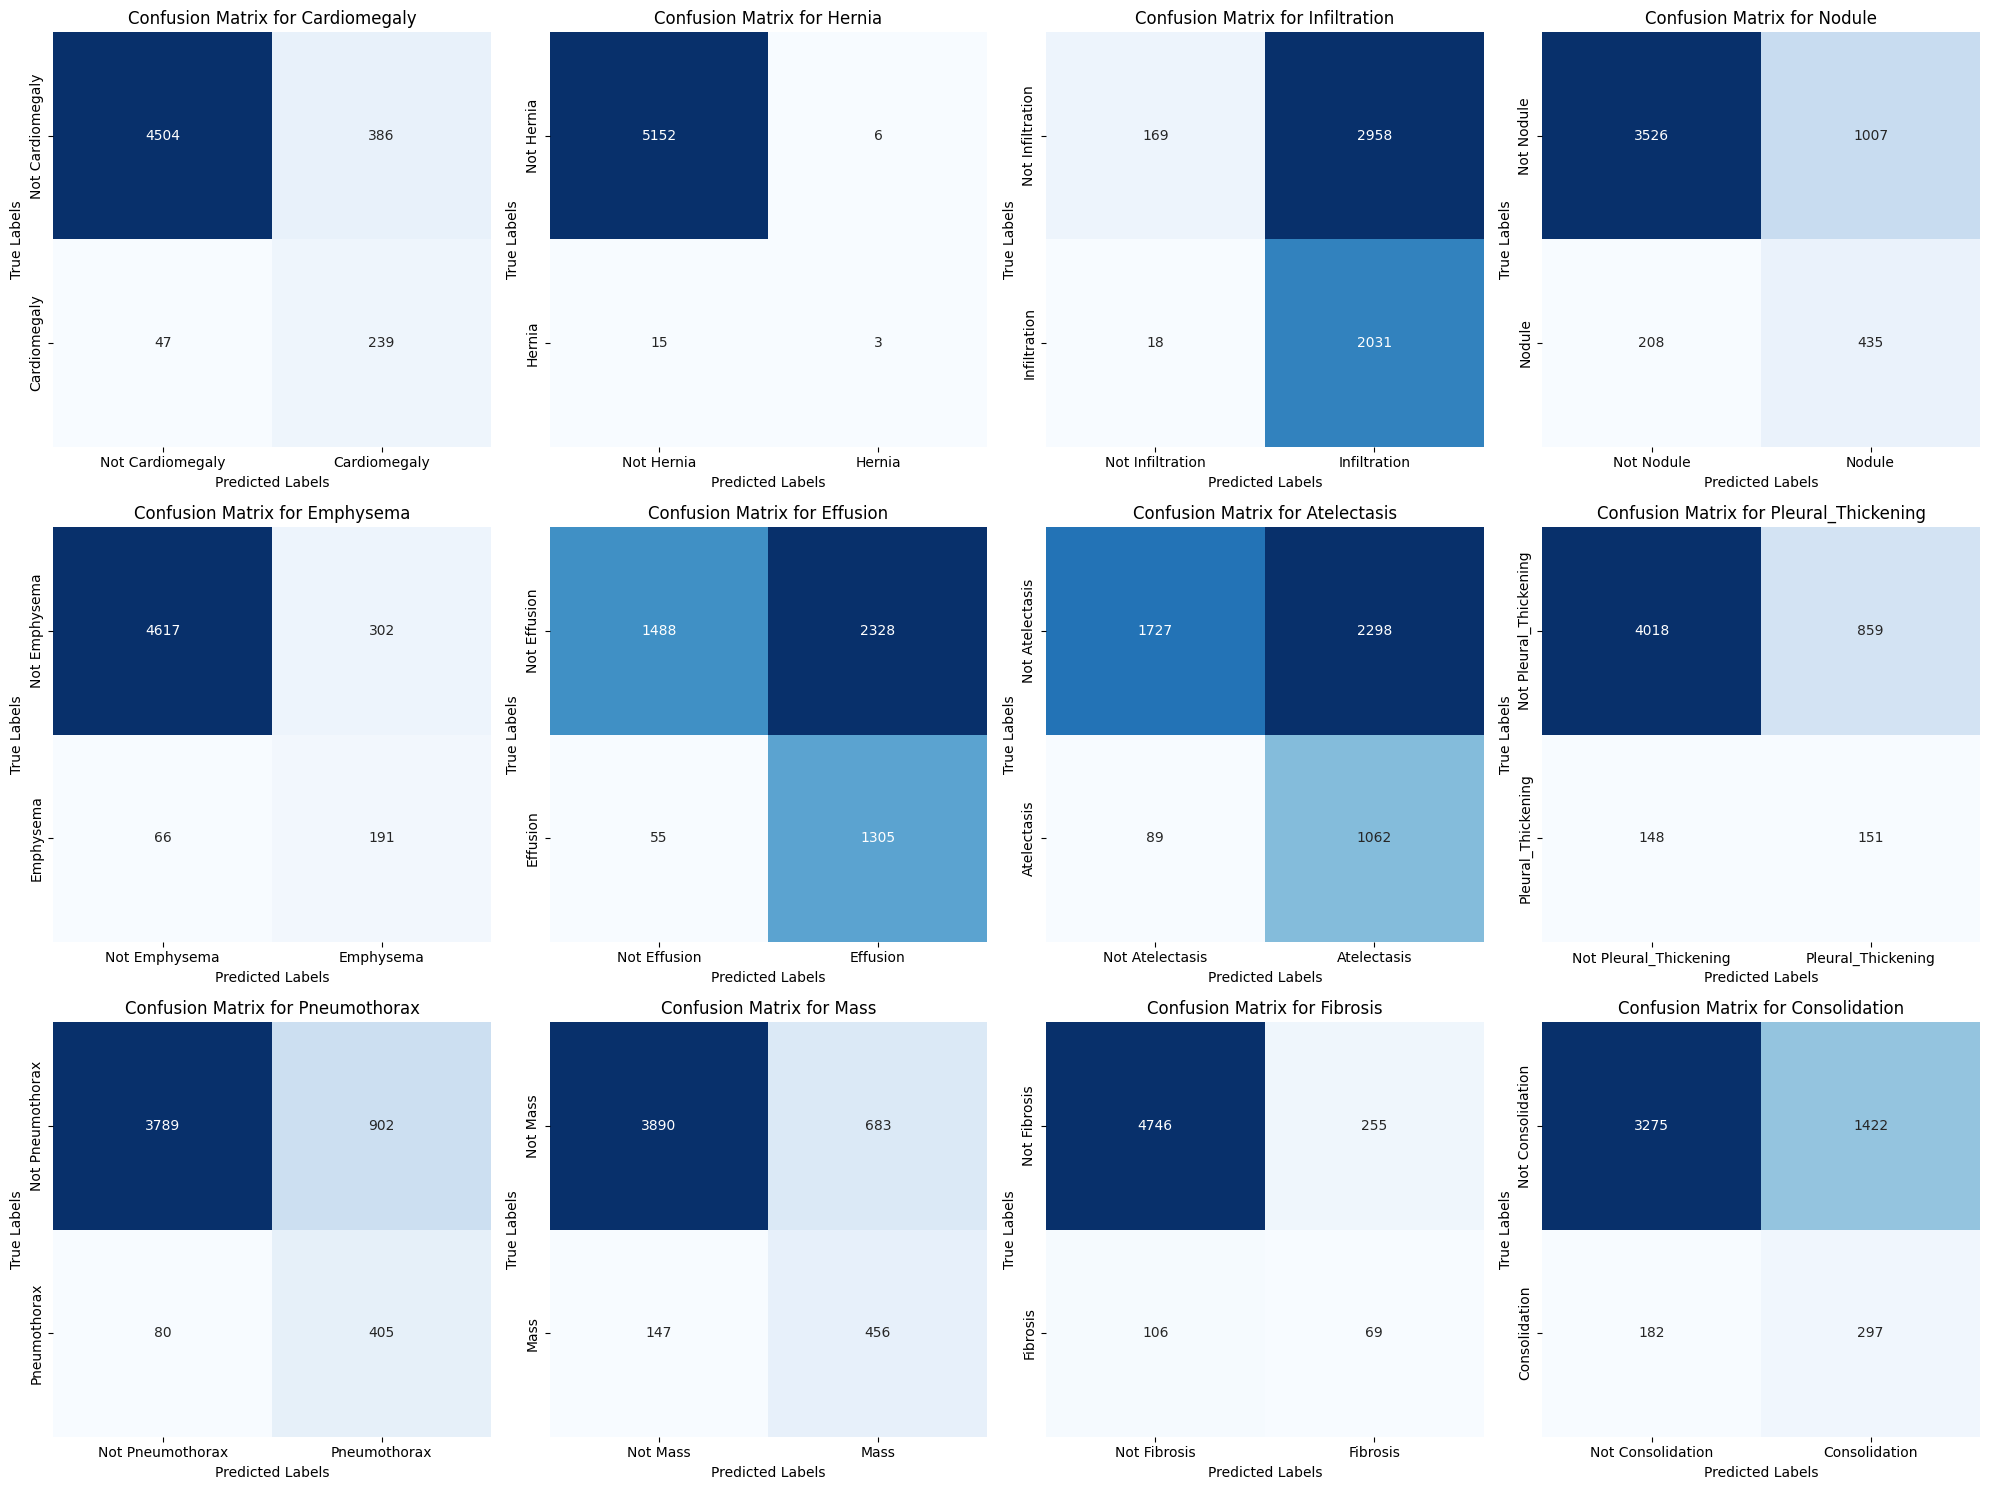

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of rows and columns for subplots
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot confusion matrix for each class
for i, (ax, class_name) in enumerate(zip(axes, all_classes)):
    sns.heatmap(matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not ' + class_name, class_name],
                yticklabels=['Not ' + class_name, class_name],
                cbar=False)
    ax.set_title(f'Confusion Matrix for {class_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Train Resnet50

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 14)

loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3  # Starting learning rate
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
threshold = 0.1

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, precision, recall, f1 = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    vtp = 0
    vfp = 0
    vfn = 0
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vprediction = (torch.sigmoid(voutputs) >= threshold).float()
            vtp += torch.sum(vlabels * vprediction).item()
            vfp += torch.sum(torch.clamp(vprediction - vlabels, min = 0, max = 1)).item()
            vfn += torch.sum(torch.clamp(vlabels - vprediction, min = 0, max = 1)).item()
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    vprecision = vtp / (vtp+vfp+1e-8)
    vrecall = vtp / (vtp+vfn+1e-8)
    vf1 = 2 * ((vprecision*vrecall) / (vprecision+vrecall+1e-8))
    avg_vloss = running_vloss / (i + 1)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('PRECISION train {} valid {}'.format(precision, vprecision))
    print('RECALL train {} valid {}'.format(recall, vrecall))
    print('F1 train {} valid {}'.format(f1, vf1))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

        # checkpoint
        model_path = os.path.join(checkpoint_dir, 'model_{}_{}.pt'.format(timestamp, epoch_number))
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
model_path = os.path.join(checkpoint_dir, 'resnet50finalmodel.pth')
torch.save(model.state_dict(), model_path)

Test Resnet50

In [ ]:
PATH = '/content/drive/MyDrive/AI_builder/models/resnet50finalmodel.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model.eval()
y_actual = []
y_predict = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        y_actual.extend(labels.cpu().numpy())
        y_predict.extend(preds.cpu().numpy())

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

y_actual = np.array(y_actual)
y_predict = np.array(y_predict)

matrix = multilabel_confusion_matrix(y_actual, y_predict)

report = classification_report(y_actual, y_predict, target_names=list(all_classes))

print("\nClassification Report:")
print(report)


Classification Report:
                    precision    recall  f1-score   support

      Cardiomegaly       0.40      0.88      0.55       286
            Hernia       0.10      0.56      0.16        18
      Infiltration       0.44      0.98      0.60      2049
            Nodule       0.30      0.79      0.43       643
         Emphysema       0.46      0.77      0.58       257
          Effusion       0.41      0.97      0.58      1360
       Atelectasis       0.32      0.96      0.48      1151
Pleural_Thickening       0.25      0.45      0.32       299
      Pneumothorax       0.41      0.84      0.55       485
              Mass       0.39      0.88      0.54       603
          Fibrosis       0.32      0.42      0.37       175
     Consolidation       0.19      0.66      0.30       479
             Edema       0.27      0.69      0.39       229
         Pneumonia       0.19      0.08      0.11       144

         micro avg       0.36      0.86      0.51      8178
         macro

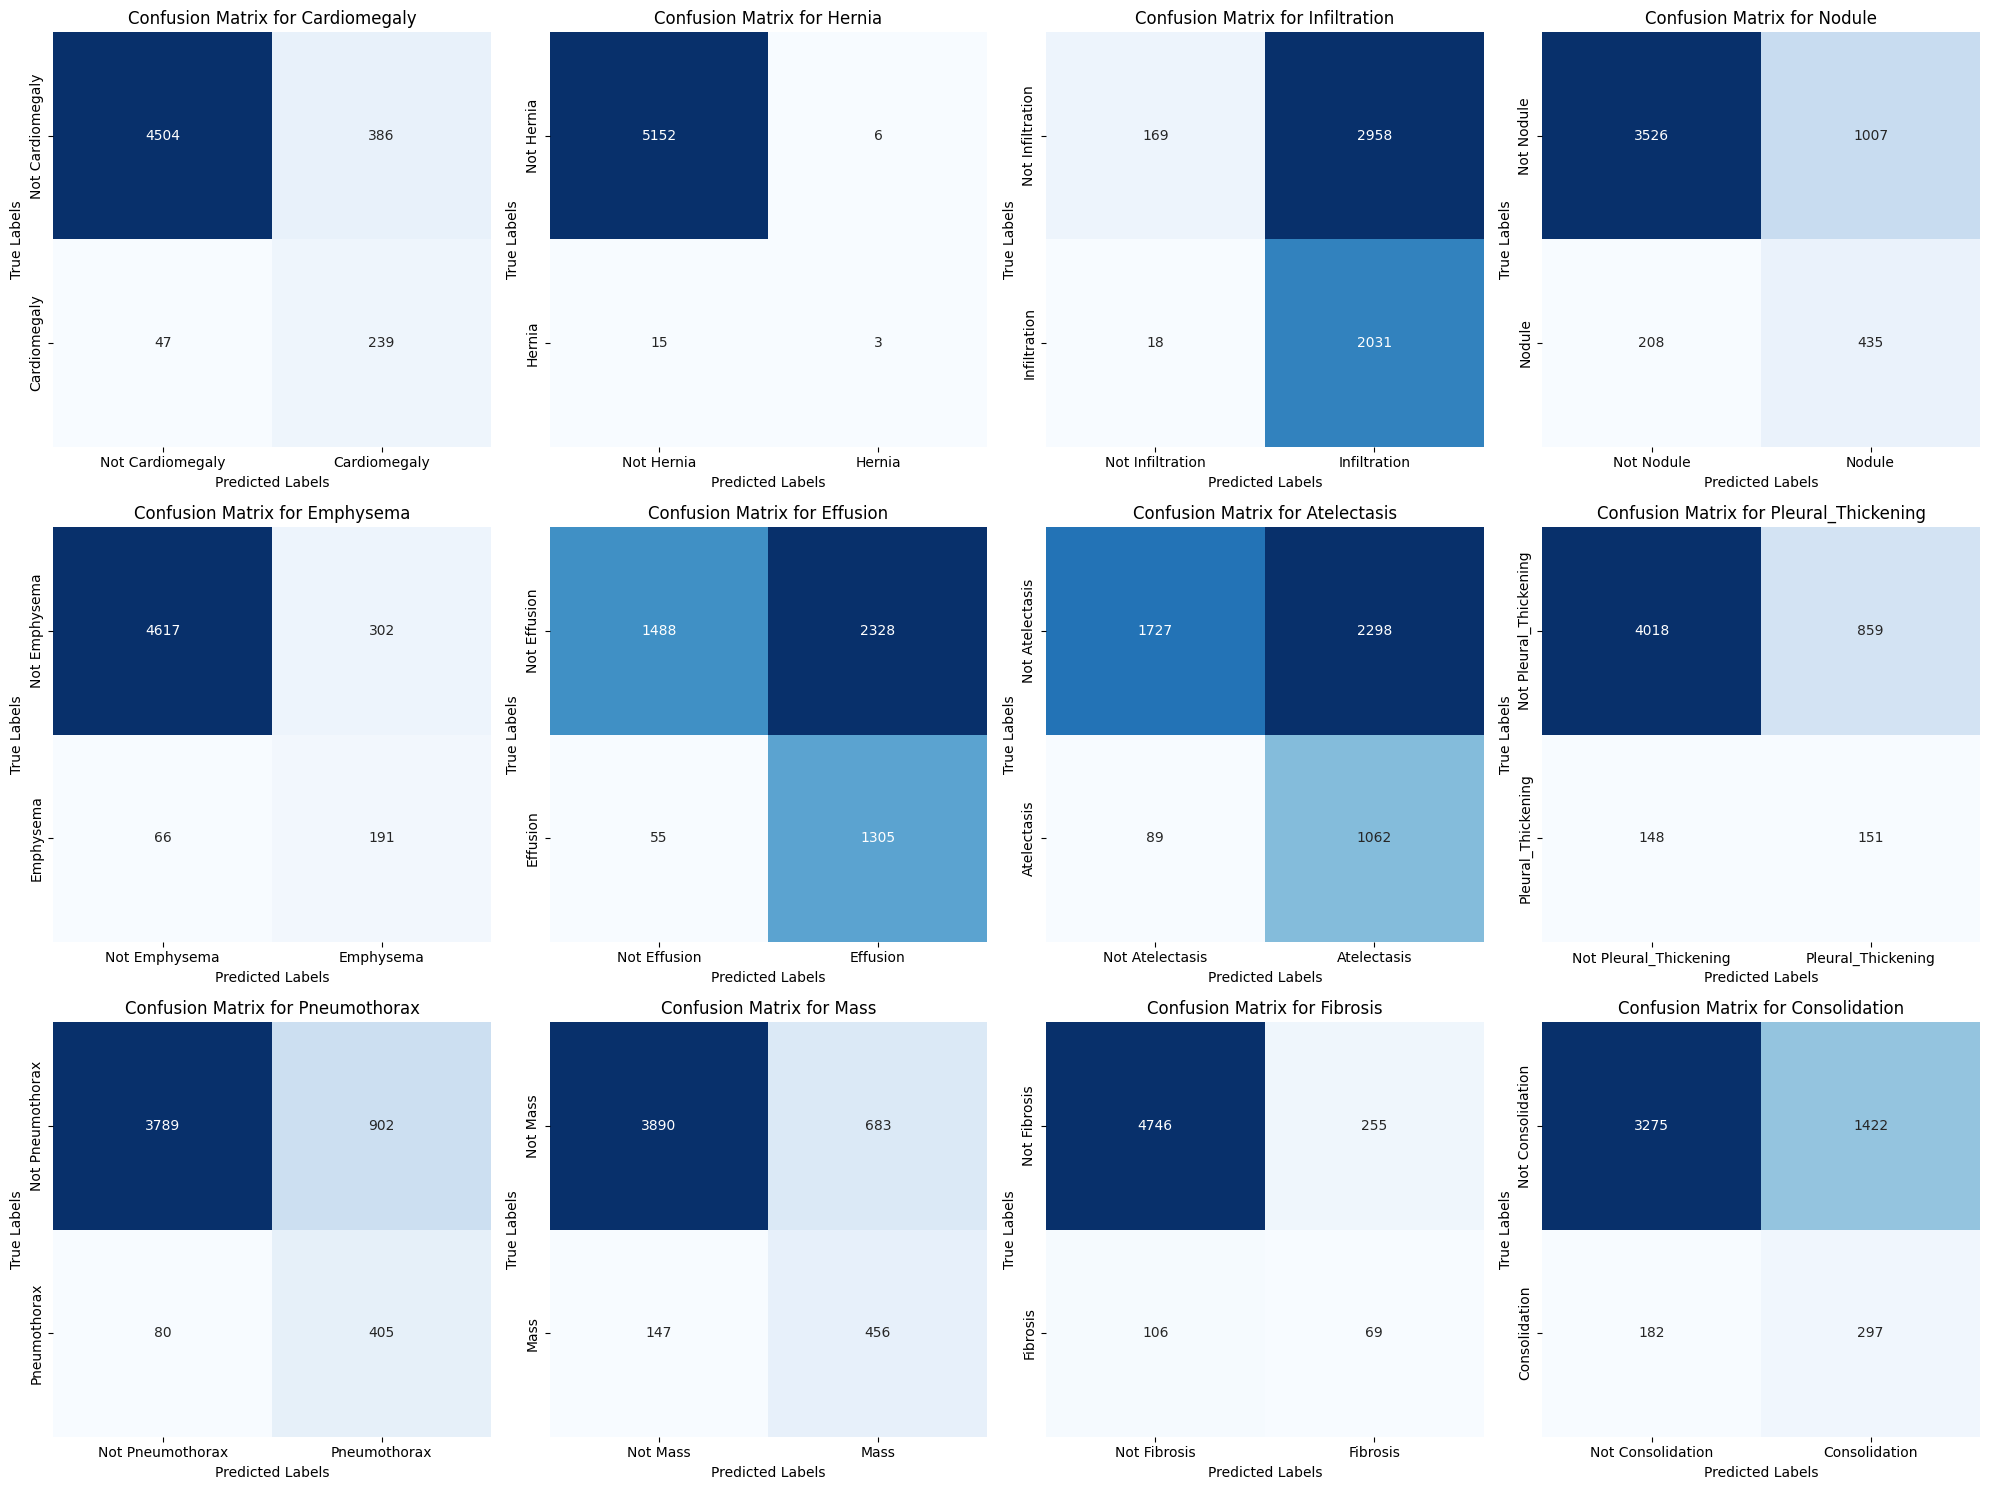

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of rows and columns for subplots
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot confusion matrix for each class
for i, (ax, class_name) in enumerate(zip(axes, all_classes)):
    sns.heatmap(matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not ' + class_name, class_name],
                yticklabels=['Not ' + class_name, class_name],
                cbar=False)
    ax.set_title(f'Confusion Matrix for {class_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()